<a href="https://colab.research.google.com/github/Priyanshi965/vision-transformer-cifar10/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import kagglehub

path = kagglehub.dataset_download("pankrzysiu/cifar10-python")
print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:01<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pankrzysiu/cifar10-python/versions/1


In [2]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filepath):
  with open(filepath, 'rb') as f:
      batch = pickle.load(f, encoding='bytes')
  return batch

def load_cifar10_data(directory):
  images = []
  labels = []
  data_batch_dir = os.path.join(directory, 'cifar-10-batches-py')
  for i in range(1, 6):
    batch_filepath = os.path.join(data_batch_dir, f'data_batch_{i}')
    batch = load_cifar10_batch(batch_filepath)
    images.append(batch[b'data'])
    labels.append(batch[b'labels'])

  test_batch_filepath = os.path.join(data_batch_dir, 'test_batch')
  test_batch = load_cifar10_batch(test_batch_filepath)
  images.append(test_batch[b'data'])
  labels.append(test_batch[b'labels'])
  images = np.concatenate(images, axis=0)
  labels = np.concatenate(labels, axis=0)
  return images, labels

cifar10_dir = path
images, labels = load_cifar10_data(cifar10_dir)
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)
print("Number of samples:", len(images))
print("Number of classes: ", len(np.unique(labels)))

Shape of images: (60000, 3072)
Shape of labels: (60000,)
Number of samples: 60000
Number of classes:  10


In [3]:
from tensorflow.keras.utils import to_categorical


images = images.reshape(-1, 32, 32, 3)

images = images.astype('float32') / 255.0


labels = to_categorical(labels, num_classes=10)

print("Shape of preprocessed images:", images.shape)
print("Shape of preprocessed labels:", labels.shape)

Shape of preprocessed images: (60000, 32, 32, 3)
Shape of preprocessed labels: (60000, 10)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_vit_classifier(input_shape, num_classes, image_size, patch_size,
num_patches, projection_dim, num_heads, transformer_layers, mlp_hidden_units,
dropout_rate):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = MlpBlock(mlp_hidden_units, dropout_rate, projection_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout_rate)(representation)
    features = MlpBlock(mlp_hidden_units, dropout_rate,
projection_dim)(representation)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

class MlpBlock(layers.Layer):
    def __init__(self, hidden_units, dropout_rate, output_dim):
        super().__init__()
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.mlp_layers = [
            layers.Dense(units=hidden_units[0], activation=tf.keras.activations.gelu),
            layers.Dropout(dropout_rate),
            layers.Dense(units=output_dim, activation=tf.keras.activations.gelu),
            layers.Dropout(dropout_rate),
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.mlp_layers:
            x = layer(x)
        return x


image_size = 32
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 8
mlp_hidden_units = [128, 128]
dropout_rate = 0.1

vit_classifier = create_vit_classifier(
    input_shape=(image_size, image_size, 3),
    num_classes=10,
    image_size=image_size,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    num_heads=num_heads,
    transformer_layers=transformer_layers,
    mlp_hidden_units=mlp_hidden_units,
    dropout_rate=dropout_rate,
)
vit_classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 48)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 64, 64)    │      7,232 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_block           │ (None, 64, 64)    │     16,576 │ layer_normalizat… │
│ (MlpBlock)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ mlp_block[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_block_1         │ (None, 64, 64)    │     16,576 │ layer_normalizat… │
│ (MlpBlock)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64)    │          0 │ mlp_block_1[0][0… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 1,206,282 (4.60 MB)

 Trainable params: 1,206,282 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

learning_rate = 0.001
weight_decay = 0.0001
epochs = 10
batch_size = 256
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
vit_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5_accuracy"),
    ],
)
history = vit_classifier.fit(
    images,
    labels,
    batch_size=batch_size,
    epochs=epochs,

    validation_split=0.1,
)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 97s 236ms/step - accuracy: 0.6621 - loss: 0.9514 - top5_accuracy: 0.9690 - val_accuracy: 0.6188 - val_loss: 1.1047 - val_top5_accuracy: 0.9543
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.6801 - loss: 0.9013 - top5_accuracy: 0.9725 - val_accuracy: 0.6278 - val_loss: 1.0964 - val_top5_accuracy: 0.9573
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6962 - loss: 0.8575 - top5_accuracy: 0.9751 - val_accuracy: 0.6230 - val_loss: 1.0925 - val_top5_accuracy: 0.9570
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.7033 - loss: 0.8389 - top5_accuracy: 0.9764 - val_accuracy: 0.6308 - val_loss: 1.1086 - val_top5_accuracy: 0.9573
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.7213 - loss: 0.7974 - top5_accuracy: 0.9792 - val_accuracy: 0.6263 - val_loss: 1.0960 - val_top5_accuracy: 0.9568
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.7306 - loss: 0.7654 -

In [6]:


loss, accuracy, top5_accuracy = vit_classifier.evaluate(images, labels)
print("Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print (f"Test Top-5 Accuracy: {top5_accuracy:.4f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6417 - loss: 1.0223 - top5_accuracy: 0.9650
Test Loss: {loss:.4f}
Test Accuracy: 0.6314
Test Top-5 Accuracy: 0.9630


In [10]:
cifar10_class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
num_images_to_predict = 5
random_indices = np.random.choice(len(images), num_images_to_predict, replace=False)
sample_images = images [random_indices]
sample_labels = labels [random_indices]

predictions = vit_classifier.predict(sample_images)

print("Predictions:")
for i in range(num_images_to_predict):
    predicted_class_index = np.argmax(predictions[i])
    true_class_index = np.argmax(sample_labels[i])
    predicted_class_name = cifar10_class_names [predicted_class_index]
    true_class_name = cifar10_class_names[true_class_index]
    print(f"Image {random_indices[i]}: True Label: {true_class_name}, Predicted Label: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions:
Image 8155: True Label: airplane, Predicted Label: airplane
Image 57628: True Label: deer, Predicted Label: dog
Image 55717: True Label: frog, Predicted Label: frog
Image 36197: True Label: bird, Predicted Label: bird
Image 11375: True Label: dog, Predicted Label: dog


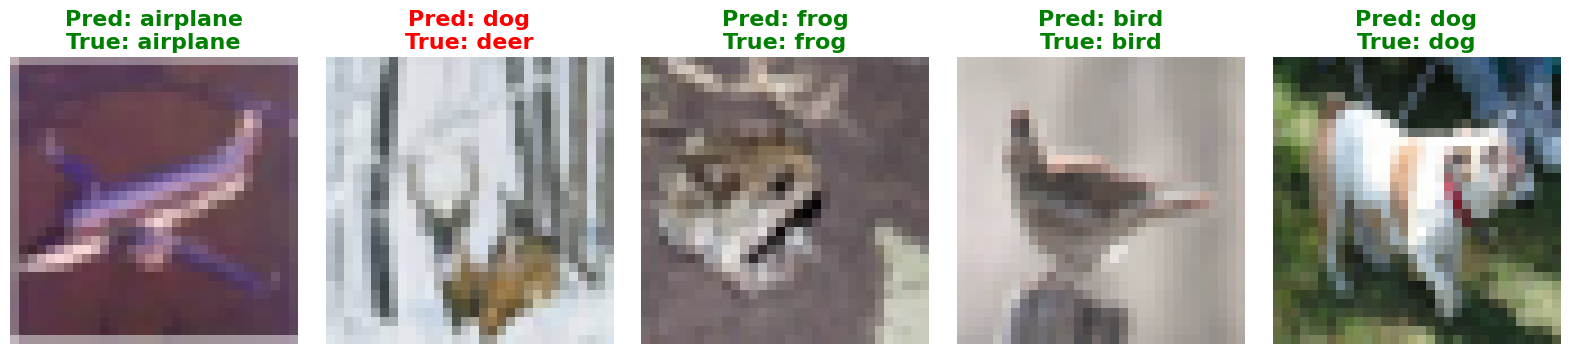

In [14]:
import matplotlib.pyplot as plt

sample_images_fixed = sample_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.1)

for i in range(num_images_to_predict):
    predicted_class_index = np.argmax(predictions[i])
    true_class_index = np.argmax(sample_labels[i])

    predicted_class_name = cifar10_class_names[predicted_class_index]
    true_class_name = cifar10_class_names[true_class_index]

    ax = plt.subplot(1, num_images_to_predict, i + 1)

    plt.imshow(sample_images_fixed[i], interpolation="nearest")

    title_color = 'green' if predicted_class_name == true_class_name else 'red'
    plt.title(f"Pred: {predicted_class_name}\nTrue: {true_class_name}",
              fontsize=16, fontweight='bold', color=title_color)
    plt.axis("off")

plt.show()